In [78]:
!pip install sentence_transformers

In [79]:
!pip install PyPDF2

In [80]:
import json
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForQuestionAnswering, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline


In [81]:

# Load your dataset
with open('dataset_edited.json', 'r') as file:
    dataset = json.load(file)['data']


In [82]:

# Extract contexts, questions, and answers
contexts = [item['context'] for item in dataset]
questions = [item['qas'][0]['question'] for item in dataset]
answers = [item['qas'][0]['answers'][0] for item in dataset]


In [83]:

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [84]:


# Initialize the tokenizer (use BertTokenizerFast)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Updated tokenize_and_align_labels function
def tokenize_and_align_labels(tokenizer, texts, questions, answers):
    input_ids = []
    attention_masks = []
    start_positions = []
    end_positions = []

    for text, question, answer in zip(texts, questions, answers):
        # Tokenize and encode the context and question
        encoded_dict = tokenizer.encode_plus(
            question, text,
            truncation='only_second',  # Truncate only the context, not the question
            max_length=512,
            padding='max_length',
            return_tensors='pt',
            return_offsets_mapping=True
        )
        offset_mapping = encoded_dict['offset_mapping'].squeeze()

        # Find the position of the answer in the context
        answer_start = answer['answer_start']
        answer_end = answer_start + len(answer['text']) - 1

        # Find the token positions of the start and end of the answer
        start_position = 0
        end_position = 0
        for i, (start, end) in enumerate(offset_mapping):
            if (start <= answer_start) and (answer_start < end):
                start_position = i
            if (start <= answer_end) and (answer_end < end):
                end_position = i
                break

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
        start_positions.append(start_position)
        end_positions.append(end_position)

    # Convert lists to tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    start_positions = torch.tensor(start_positions)
    end_positions = torch.tensor(end_positions)

    return {
        'input_ids': input_ids,
        'attention_mask': attention_masks,
        'start_positions': start_positions,
        'end_positions': end_positions
    }



In [85]:

# Split data into train and validation sets
train_contexts, val_contexts, train_questions, val_questions, train_answers, val_answers = train_test_split(
    contexts, questions, answers, test_size=0.1
)


In [86]:

# Tokenize train and validation data
train_encodings = tokenize_and_align_labels(tokenizer, train_contexts, train_questions, train_answers)
val_encodings = tokenize_and_align_labels(tokenizer, val_contexts, val_questions, val_answers)


In [87]:

# Create torch dataset
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings['input_ids'])


In [88]:

train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)


In [89]:

# Model Initialization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)

# DataLoader, Optimizer, and Scheduler setup
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# optimizer = AdamW(model.parameters(), lr=5e-3)
optimizer = AdamW(model.parameters(), lr=5e-4)

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 3)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


<ipython-input-87-8da84fce7490>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 1: Loss 3.059794942183154
Epoch 2: Loss 2.1532092733042583
Epoch 3: Loss 1.0839301508053072
Epoch 4: Loss 0.5093350281406727
Epoch 5: Loss 0.5169158999009856


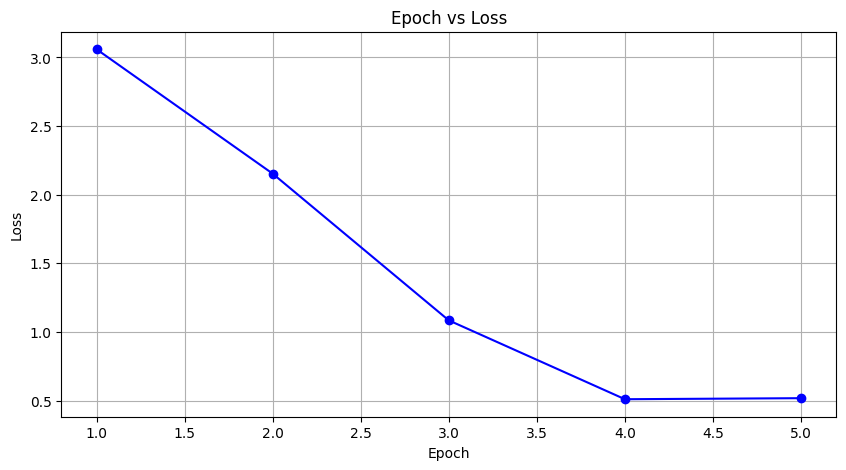

In [90]:


# Training loop
model.train()
losses = []  # List to store the losses for each epoch

for epoch in range(5):  # Number of training epochs
    epoch_loss = 0.0  # Variable to store the cumulative loss for the epoch

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()  # Accumulate the batch loss

    average_epoch_loss = epoch_loss / len(train_loader)  # Calculate the average epoch loss
    losses.append(average_epoch_loss)  # Append it to the list of losses

    print(f"Epoch {epoch+1}: Loss {average_epoch_loss}")

# Plotting epoch vs loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-', color='b')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [127]:
import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)


In [102]:
# Evaluation loop
model.eval()
total = 0
match_count = 0
model_st = SentenceTransformer('paraphrase-MiniLM-L6-v2')

with torch.no_grad():
    for batch in val_loader:
        try:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            start_preds = torch.argmax(outputs['start_logits'], dim=1)
            end_preds = torch.argmax(outputs['end_logits'], dim=1)

            # Convert the start and end positions to lists
            start_positions = start_positions.tolist()
            end_positions = end_positions.tolist()

            for i in range(len(start_preds)):
                pred_answer = tokenizer.decode(input_ids[i][start_preds[i]:end_preds[i]+1])
                true_answer = tokenizer.decode(input_ids[i][start_positions[i]:end_positions[i]+1])
                predicted_answers.append(pred_answer)
                actual_answers.append(true_answer)

                # Encode statements
                embedding1 = model_st.encode(pred_answer, convert_to_tensor=True)
                embedding2 = model_st.encode(true_answer, convert_to_tensor=True)

                # Compute cosine similarity
                cosine_similarity = util.pytorch_cos_sim(embedding1, embedding2)

                # Check if similarity score is more than 0.50
                if cosine_similarity.item() > 0.50:
                    match_count += 1

            total += input_ids.size(0)
        except Exception as e:
            print(f"An error occurred: {e}")
Finetuned_accuracy=match_count*100 / total
# Print the total matches
print(f"Total Matches: {match_count}")
print("Accuracy:", Finetuned_accuracy)


<ipython-input-87-8da84fce7490>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Total Matches: 64
Accuracy: 64.0


Training on pretrained model

In [94]:
# Model Initialization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pt = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [95]:
# Training loop
model_pt.train()
losses = []  # List to store the losses for each epoch

for epoch in range(5):  # Number of training epochs
    epoch_loss = 0.0  # Variable to store the cumulative loss for the epoch

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        outputs = model_pt(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()  # Accumulate the batch loss

    average_epoch_loss = epoch_loss / len(train_loader)  # Calculate the average epoch loss
    losses.append(average_epoch_loss)  # Append it to the list of losses

    print(f"Epoch {epoch+1}: Loss {average_epoch_loss}")


<ipython-input-87-8da84fce7490>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 1: Loss 6.2310298553534915
Epoch 2: Loss 6.227458208799362
Epoch 3: Loss 6.227775739771979
Epoch 4: Loss 6.225178641932351
Epoch 5: Loss 6.2252702329839975


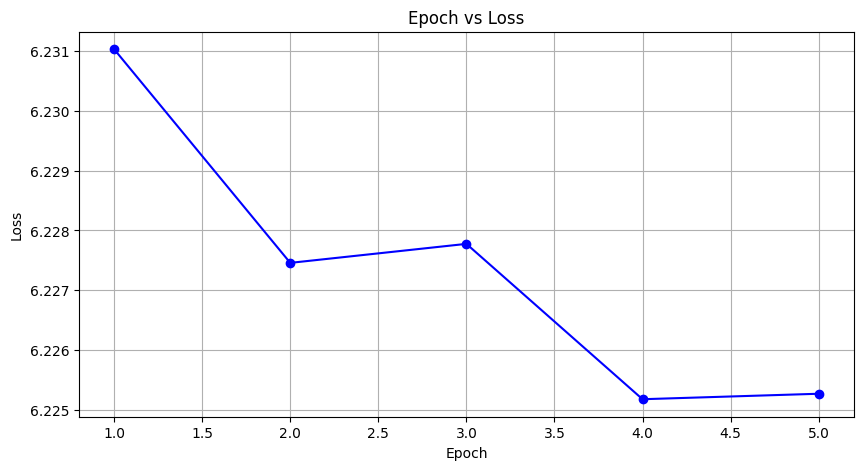

In [99]:
# Plotting epoch vs loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-', color='b')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [101]:

# Evaluation loop
model_pt.eval()
total = 0
match_count_qa = 0
match_count_st = 0
model_st = SentenceTransformer('paraphrase-MiniLM-L6-v2')
predicted_answers=[]
actual_answers=[]
with torch.no_grad():
    for batch in val_loader:
        try:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)
            outputs = model_pt(input_ids, attention_mask=attention_mask)
            start_preds = torch.argmax(outputs['start_logits'], dim=1)
            end_preds = torch.argmax(outputs['end_logits'], dim=1)

            # Convert the start and end positions to lists
            start_positions = start_positions.tolist()
            end_positions = end_positions.tolist()

            for i in range(len(start_preds)):
                pred_answer = tokenizer.decode(input_ids[i][start_preds[i]:end_preds[i] + 1])
                true_answer = tokenizer.decode(input_ids[i][start_positions[i]:end_positions[i] + 1])
                predicted_answers.append(pred_answer)
                actual_answers.append(true_answer)

                # Check QA model match
                if pred_answer == true_answer:
                    match_count_qa += 1

                # Encode statements
                embedding1 = model_st.encode(pred_answer, convert_to_tensor=True)
                embedding2 = model_st.encode(true_answer, convert_to_tensor=True)

                # Compute cosine similarity
                cosine_similarity = util.pytorch_cos_sim(embedding1, embedding2)

                # Check if SentenceTransformer model match
                if cosine_similarity.item() > 0.50:
                    match_count_st += 1

            total += input_ids.size(0)
        except Exception as e:
            print(f"An error occurred: {e}")

Pretrained_accuracy=match_count_st *100 / total
print(f"Total Matches: {match_count_st}")
print(f"Accuracy : {Pretrained_accuracy}")


<ipython-input-87-8da84fce7490>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Total Matches: 9
Accuracy : 9.0


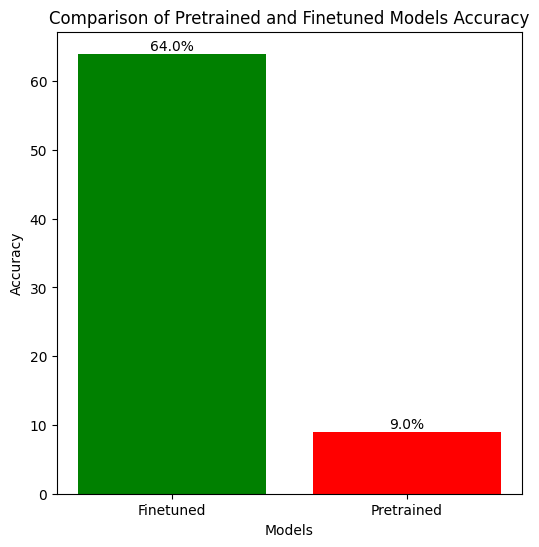

In [115]:
import matplotlib.pyplot as plt

# Data
labels = ['Finetuned','Pretrained']
values = [Finetuned_accuracy, Pretrained_accuracy]  # acc and pre values
colors = ['green','red']  # Different colors for each bar

bar_width=0.3
plt.figure(figsize=(6, 6))
bars = plt.bar(labels, values, color=colors)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Pretrained and Finetuned Models Accuracy')

# Adding the text on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{round(yval, 2)}%", va='bottom', ha='center')

# Show the plot
plt.show()



In [41]:
len(incorrect_predictions)

80

# Post Processing

In [128]:
import PyPDF2
import re
# Function to extract text from PDF
def extract_text_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = [reader.pages[i].extract_text() for i in range (len(reader.pages))]
        return "\n\n".join(text)  # Use double newline as paragraph delimiter

# Function to split text into paragraphs
def split_into_paragraphs(text, delimiter='\n\n'):
    return text.split(delimiter)
def find_relevant_paragraph(question, paragraphs, keyword_threshold=0.3):
    # Tokenize and preprocess the question
    question_tokens = re.findall(r'\b\w+\b', question.lower())

    # Calculate relevance score for each paragraph based on keyword matching
    relevance_scores = []
    for paragraph in paragraphs:
        paragraph_tokens = re.findall(r'\b\w+\b', paragraph.lower())
        common_keywords = set(question_tokens).intersection(paragraph_tokens)
        relevance_score = len(common_keywords) / len(question_tokens)
        relevance_scores.append(relevance_score)

    # Find the index of the paragraph with the highest relevance score
    most_relevant_idx = relevance_scores.index(max(relevance_scores))

    # Check if the relevance score meets the threshold
    if relevance_scores[most_relevant_idx] >= keyword_threshold:
        return paragraphs[most_relevant_idx]
    else:
        # If no paragraph meets the threshold, return None
        return None

def extract_limited_context(page, num_lines=4):
    paragraphs = page.split('\n\n')
    context = ""
    for i in range(min(num_lines, len(paragraphs))):
        context += paragraphs[i] + '\n\n'
    return context.strip()
# Main function
def get_limited_context_for_question(pdf_path, question):
    text = extract_text_from_pdf(pdf_path)
    paragraphs = split_into_paragraphs(text)
    relevant_paragraph = find_relevant_paragraph(question, paragraphs)
    limited_context = extract_limited_context(relevant_paragraph)
    return limited_context


In [117]:


def context_extraction(context,question,additional_context=10,model="distilbert-base-cased-distilled-squad"):
    qa_pipeline = pipeline("question-answering", model=model)
    answer = qa_pipeline(question=question, context=context)

    # Extract the start and end index of the answer
    start_index = answer['start']
    end_index = answer['end']

    # Split the context into lines or sentences
    sentences = context.split('. ')

    # Find the sentence that contains the answer
    answer_sentence_index = None
    char_count = 0
    for i, sentence in enumerate(sentences):
        char_count += len(sentence) + 2  # Adding 2 for the period and space
        if start_index < char_count:
            answer_sentence_index = i
            break

    # Extract surrounding sentences
    if answer_sentence_index is not None:
        start = max(answer_sentence_index - additional_context, 0)
        end = min(answer_sentence_index + additional_context + 1, len(sentences))
        extended_context = '. '.join(sentences[start:end])
    else:
        extended_context = answer['answer']

    return extended_context


In [118]:
def answer_question(question, context, model, tokenizer):
    # Tokenize the input question and context
    inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors="pt", truncation=True, max_length=512)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    # Predict answer spans
    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        answer_start_scores = outputs.start_logits
        answer_end_scores = outputs.end_logits

    # Find the tokens with the highest `start` and `end` scores
    answer_start = torch.argmax(answer_start_scores)
    answer_end = torch.argmax(answer_end_scores) + 1

    # Check if the model found a valid answer (start should be before end)
    # if answer_end <= answer_start:
    #     return "Answer not found."

    # Convert the tokens to the answer text
    answer_tokens = input_ids[0][answer_start:answer_end]
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(answer_tokens))

    return answer.strip()

# # Example usage
# context = "Property and equipment are initially recorded at cost and include land, buildings and improvements, fixtures and equipment, transportation equipment, and construction in progress."
# question = "What does Walmart's property and equipment include?"


In [119]:
def remove_question_from_answer(question, answer):
    # Split the answer on the [SEP] token
    parts = answer.split('[SEP]')
    # print(parts)
    if len(parts) > 1:
        # The actual answer should be after the [SEP] token
        answer = parts[1].strip()
    else:
        # If [SEP] is not found, use the original answer
        answer = answer.strip()

    return answer


## Input the user provided document and question here

In [124]:
pdf_path = '2022-Annual-Report-disney-testing.pdf'
# question = "How much revenue did Amazon's international consumer segment generate in 2022?"
# question="What are the two operational segments of The Walt Disney Company?"
question="What types of training and development programs are offered to employees for career growth?"


In [125]:

# limited_context = get_limited_context_for_question(pdf_path, question)
context= context_extraction(get_limited_context_for_question(pdf_path, question), question)
print(context)

•Health, wellness, family resources, and other benefits: Disney’s benefit offerings are designed to meet the varied
and evolving needs of a diverse workforce across businesses and geographies while helping our employees care forthemselves and their families. We provide:
◦Healthcare options aimed at improving quality of care while limiting out-of-pocket costs
◦Family care resources, such as childcare programs for employees, including access to onsite/community centers,
enhanced back-up care choices to include personal caregivers, childcare referral assistance and center discounts,homework help, a variety of parenting educational resources and a family building benefit supporting fertilitytreatments, adoptions or surrogacy
◦Free mental and behavioral health resources, including on-demand access to the Employee Assistance Program for
employees and their dependents
◦Two Centers for Living Well that offer convenient, on-demand access to board-certified physicians and counselors
◦A multi-lay

In [126]:
# answer = answer_question(question, context, model, tokenizer)
processed_answer = remove_question_from_answer(question, answer_question(question, context, model, tokenizer))
print(f"Answer: {processed_answer}")

Answer: • health, wellness, family resources, and other benefits : disney ’ s benefit offerings are designed to meet the varied and evolving needs of a diverse workforce across businesses and geographies while helping our employees care forthemselves and their families. we provide : [UNK] options aimed at improving quality of care while limiting out - of - pocket costs [UNK] care resources, such as childcare programs for employees, including access to onsite / community centers, enhanced back - up care choices to include personal caregivers, childcare referral assistance and center discounts, homework help, a variety of parenting educational resources and a family building benefit supporting fertilitytreatments, adoptions or surrogacy [UNK] mental and behavioral health resources, including on - demand access to the employee assistance program for employees and their dependents [UNK] centers for living well that offer convenient, on - demand access to board - certified physicians and co

In [77]:

context= "During the last quarter, Spacely Sprockets' total expenses amounted to 500 million dollars."
question="What was the total expenses of Spacely Sprockets in the last quarter?"
processed_answer = remove_question_from_answer(question, answer_question(question, context, model, tokenizer))
print(f"Answer: {processed_answer}")


Answer: 500 million dollars
